Decision Trees

## Scratch Implementation

In [4]:
import numpy as np
from collections import Counter

In [5]:
# Entropy
def entropy(s):
    counts = np.bincount(s)
    percentages = counts / len(s)
    
    entropy = 0
    for pct in percentages:
        if pct > 0:
            entropy += pct * np.log2(pct)
    return -entropy

In [1]:
s = [0, 0, 0, 0, 0, 0, 0, 1, 1, 1]
print(f'Entropy: {np.round(entropy(s), 5)}')

Entropy: 0.88129


In [2]:
# Information Gain
def information_gain(parent, left_child, right_child):
    num_left = len(left_child) / len(parent)
    num_right = len(right_child) / len(parent)
    
    gain = entropy(parent) - (num_left * entropy(left_child) + num_right * entropy(right_child))
    return gain

In [3]:
parent = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1]
left_child = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
right_child = [0, 0, 0, 0, 1, 1, 1, 1]

print(f'Information gain: {np.round(information_gain(parent, left_child, right_child), 5)}')

Information gain: 0.18094


In [6]:
# Recursion
def factorial(x):
    # Exit condition
    if x == 1:
        return 1
    return x * factorial(x - 1)

print(f'Factorial of 5 is {factorial(5)}')

Factorial of 5 is 120


We'll need two classes

    Node - implements a single node of a decision tree

    DecisionTree - implements the algorithm
The Node class is here to store the data about the feature, threshold, data going left and right, information gain, and the leaf node value

All are initially set to None

The leaf node value is available only for leaf nodes

In [7]:
class Node:
    '''
    Helper class which implements a single tree node.
    '''
    def __init__(self, feature=None, threshold=None, data_left=None, data_right=None, gain=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.data_left = data_left
        self.data_right = data_right
        self.gain = gain
        self.value = value

The *DecisionTree* class contains a bunch of methods

    The constructor holds values for min_samples_split and max_depth. 
These are hyperparameters. The first one is used to specify a minimum number of samples required to split a node, and the second one specifies a maximum depth of a tree. Both are used in recursive functions as exit conditions

    The _entropy(s) function calculates the impurity of an input vectors

    The _information_gain(parent, left_child, right_child) calculates the information gain value of a split between a parent and two children

    The _best_split(X, y) function calculates the best splitting parameters for input features X and a target variable y

It does so by iterating over every column in X and every thresold value in every column to find the optimal split using information gain
    
    The _build(X, y, depth) function recursively builds a decision tree until stopping criterias are met (hyperparameters in the constructor)

    The fit(X, y) function calls the _build() function and stores the built tree to the constructor

    The _predict(x) function traverses the tree to classify a single instance
The predict(X) function applies the _predict() function to every instance in matrix X

In [8]:
class DecisionTree:
    '''
    Class which implements a decision tree classifier algorithm.
    '''
    def __init__(self, min_samples_split=2, max_depth=5):
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.root = None
        
    @staticmethod
    def _entropy(s):
        '''
        Helper function, calculates entropy from an array of integer values.
        
        :param s: list
        :return: float, entropy value
        '''
        # Convert to integers to avoid runtime errors
        counts = np.bincount(np.array(s, dtype=np.int64))
        # Probabilities of each class label
        percentages = counts / len(s)

        # Caclulate entropy
        entropy = 0
        for pct in percentages:
            if pct > 0:
                entropy += pct * np.log2(pct)
        return -entropy
    
    def _information_gain(self, parent, left_child, right_child):
        '''
        Helper function, calculates information gain from a parent and two child nodes.
        
        :param parent: list, the parent node
        :param left_child: list, left child of a parent
        :param right_child: list, right child of a parent
        :return: float, information gain
        '''
        num_left = len(left_child) / len(parent)
        num_right = len(right_child) / len(parent)
        
        # One-liner which implements the previously discussed formula
        return self._entropy(parent) - (num_left * self._entropy(left_child) + num_right * self._entropy(right_child))
    
    def _best_split(self, X, y):
        '''
        Helper function, calculates the best split for given features and target
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: dict
        '''
        best_split = {}
        best_info_gain = -1
        n_rows, n_cols = X.shape
        
        # For every dataset feature
        for f_idx in range(n_cols):
            X_curr = X[:, f_idx]
            # For every unique value of that feature
            for threshold in np.unique(X_curr):
                # Construct a dataset and split it to the left and right parts
                # Left part includes records lower or equal to the threshold
                # Right part includes records higher than the threshold
                df = np.concatenate((X, y.reshape(1, -1).T), axis=1)
                df_left = np.array([row for row in df if row[f_idx] <= threshold])
                df_right = np.array([row for row in df if row[f_idx] > threshold])

                # Do the calculation only if there's data in both subsets
                if len(df_left) > 0 and len(df_right) > 0:
                    # Obtain the value of the target variable for subsets
                    y = df[:, -1]
                    y_left = df_left[:, -1]
                    y_right = df_right[:, -1]

                    # Caclulate the information gain and save the split parameters
                    # if the current split if better then the previous best
                    gain = self._information_gain(y, y_left, y_right)
                    if gain > best_info_gain:
                        best_split = {
                            'feature_index': f_idx,
                            'threshold': threshold,
                            'df_left': df_left,
                            'df_right': df_right,
                            'gain': gain
                        }
                        best_info_gain = gain
        return best_split
    
    def _build(self, X, y, depth=0):
        '''
        Helper recursive function, used to build a decision tree from the input data.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :param depth: current depth of a tree, used as a stopping criteria
        :return: Node
        '''
        n_rows, n_cols = X.shape
        
        # Check to see if a node should be leaf node
        if n_rows >= self.min_samples_split and depth <= self.max_depth:
            # Get the best split
            best = self._best_split(X, y)
            # If the split isn't pure
            if best['gain'] > 0:
                # Build a tree on the left
                left = self._build(
                    X=best['df_left'][:, :-1], 
                    y=best['df_left'][:, -1], 
                    depth=depth + 1
                )
                right = self._build(
                    X=best['df_right'][:, :-1], 
                    y=best['df_right'][:, -1], 
                    depth=depth + 1
                )
                return Node(
                    feature=best['feature_index'], 
                    threshold=best['threshold'], 
                    data_left=left, 
                    data_right=right, 
                    gain=best['gain']
                )
        # Leaf node - value is the most common target value 
        return Node(
            value=Counter(y).most_common(1)[0][0]
        )
    
    def fit(self, X, y):
        '''
        Function used to train a decision tree classifier model.
        
        :param X: np.array, features
        :param y: np.array or list, target
        :return: None
        '''
        # Call a recursive function to build the tree
        self.root = self._build(X, y)
        
    def _predict(self, x, tree):
        '''
        Helper recursive function, used to predict a single instance (tree traversal).
        
        :param x: single observation
        :param tree: built tree
        :return: float, predicted class
        '''
        # Leaf node
        if tree.value != None:
            return tree.value
        feature_value = x[tree.feature]
        
        # Go to the left
        if feature_value <= tree.threshold:
            return self._predict(x=x, tree=tree.data_left)
        
        # Go to the right
        if feature_value > tree.threshold:
            return self._predict(x=x, tree=tree.data_right)
        
    def predict(self, X):
        '''
        Function used to classify new instances.
        
        :param X: np.array, features
        :return: np.array, predicted classes
        '''
        # Call the _predict() function for every observation
        return [self._predict(x, self.root) for x in X]

In [9]:
from sklearn.datasets import load_iris

iris = load_iris()

X = iris.data[:, [2, 3]]
y = iris['target']

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [11]:
model = DecisionTree()
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [12]:
np.array(preds, dtype=np.int64)

array([2, 0, 0, 1, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0,
       1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0,
       0])

In [13]:
y_test

array([2, 0, 0, 2, 1, 1, 2, 1, 2, 0, 0, 2, 0, 1, 0, 1, 2, 1, 1, 2, 2, 0,
       1, 2, 1, 1, 1, 2, 0, 2, 0, 0, 1, 1, 2, 2, 0, 0, 0, 1, 2, 2, 1, 0,
       0])

As you can see, the arrays are identical. Let's calculate the accuracy to confirm this:

In [14]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test, preds)

0.9777777777777777

## Scikit Learn Implementation

In [15]:
from sklearn import datasets
import numpy as np


iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))

Class labels: [0 1 2]


In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [ ]:
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))

Labels counts in y: [50 50 50]
Labels counts in y_train: [35 35 35]
Labels counts in y_test: [15 15 15]


/usr/local/lib/python3.8/dist-packages/mlxtend/plotting/decision_regions.py:244: MatplotlibDeprecationWarning: Passing unsupported keyword arguments to axis() will raise a TypeError in 3.3.
  ax.axis(xmin=xx.min(), xmax=xx.max(), y_min=yy.min(), y_max=yy.max())


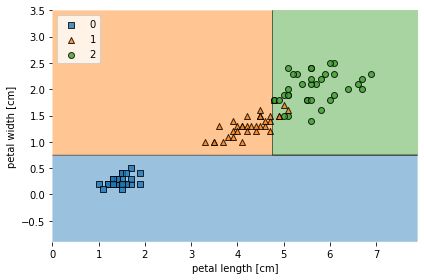

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from mlxtend.plotting import plot_decision_regions


tree = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=2, 
                              random_state=1)
tree.fit(X_train, y_train)


plot_decision_regions(X_train, y_train, tree)

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [18]:
from sklearn.metrics import accuracy_score
pred_sk = tree.predict(X_test)
accuracy_score(y_test, pred_sk)

0.9555555555555556

In [ ]:
# try changing the value of max_depth

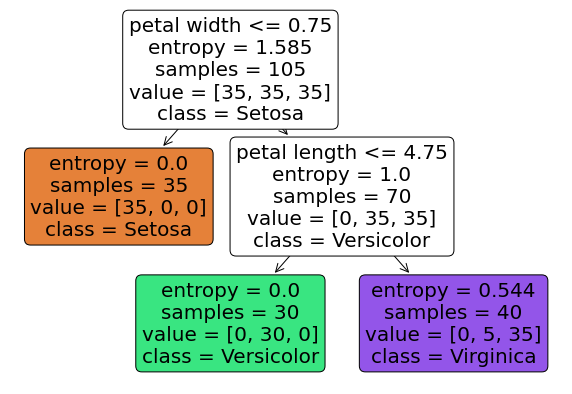

In [ ]:
from sklearn.tree import plot_tree


plt.figure(figsize=(10, 7))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica'],
          feature_names=['petal length', 
                         'petal width']) 

plt.show()

# Decision Tree Pruning 

In [5]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np


iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, 
                         shuffle=True, random_state=1, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.3,
                         shuffle=True, random_state=1, stratify=y_temp)

print('Train size', X_train.shape, 'class proportions', np.bincount(y_train))
print('Valid size', X_valid.shape, 'class proportions', np.bincount(y_valid))
print('Test size', X_test.shape, 'class proportions', np.bincount(y_test))

Train size (94, 2) class proportions [32 31 31]
Valid size (41, 2) class proportions [13 14 14]
Test size (15, 2) class proportions [5 5 5]


# Baseline tree

In [6]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=1)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
valid_acc = tree.score(X_valid, y_valid)
test_acc = tree.score(X_test, y_test)

print(f'Training accuracy: {train_acc*100:.2f}%')
print(f'Validation accuracy: {valid_acc*100:.2f}%')
print(f'Depth: {tree.get_depth()}')

Training accuracy: 100.00%
Validation accuracy: 85.37%
Depth: 4


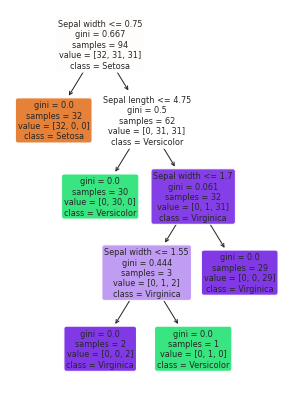

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


plt.figure(figsize=(5, 7))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          feature_names=['Sepal length', 'Sepal width',
                         'Petal length', 'Petal width'],
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica']
         )

#plt.tight_layout()
plt.show()

# Minimum Samples Per Leaf (Pre-pruning)

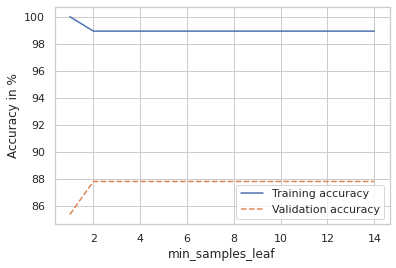

In [8]:
all_train_acc = []
all_valid_acc = []
all_hyperparam = []


for i in range(1, 15):
    tree = DecisionTreeClassifier(min_samples_leaf=i, random_state=1)
    tree.fit(X_train, y_train)
    train_acc = tree.score(X_train, y_train)
    valid_acc = tree.score(X_valid, y_valid)
    
    all_train_acc.append(train_acc*100)
    all_valid_acc.append(valid_acc*100)
    all_hyperparam.append(i)
    
plt.plot(all_hyperparam, all_train_acc, label='Training accuracy')
plt.plot(all_hyperparam, all_valid_acc, ls='--', label='Validation accuracy')
plt.xlabel('min_samples_leaf')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

In [9]:
tree = DecisionTreeClassifier(min_samples_leaf=2, random_state=1)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
valid_acc = tree.score(X_valid, y_valid)
test_acc = tree.score(X_test, y_test)

print(f'Training accuracy: {train_acc*100:.2f}%')
print(f'Validation accuracy: {valid_acc*100:.2f}%')
print(f'Depth: {tree.get_depth()}')

Training accuracy: 98.94%
Validation accuracy: 87.80%
Depth: 3


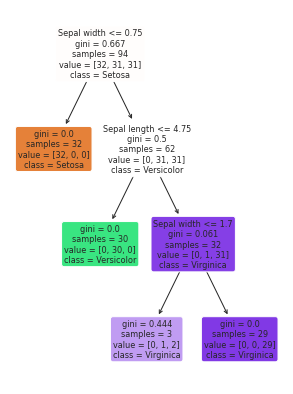

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


plt.figure(figsize=(5, 7))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          feature_names=['Sepal length', 'Sepal width',
                         'Petal length', 'Petal width'],
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica']
         )

#plt.tight_layout()
plt.show()

# Max Depth (Pre-pruning)

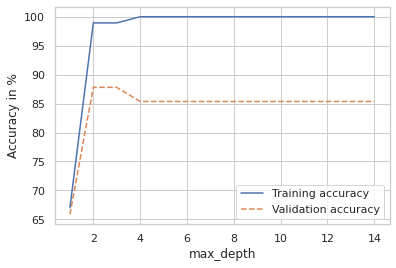

In [11]:
all_train_acc = []
all_valid_acc = []
all_hyperparam = []


for i in range(1, 15):
    tree = DecisionTreeClassifier(max_depth=i, random_state=1)
    tree.fit(X_train, y_train)
    train_acc = tree.score(X_train, y_train)
    valid_acc = tree.score(X_valid, y_valid)
    
    all_train_acc.append(train_acc*100)
    all_valid_acc.append(valid_acc*100)
    all_hyperparam.append(i)
    
plt.plot(all_hyperparam, all_train_acc, label='Training accuracy')
plt.plot(all_hyperparam, all_valid_acc, ls='--', label='Validation accuracy')
plt.xlabel('max_depth')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

Training accuracy: 98.94%
Validation accuracy: 87.80%
Depth: 2


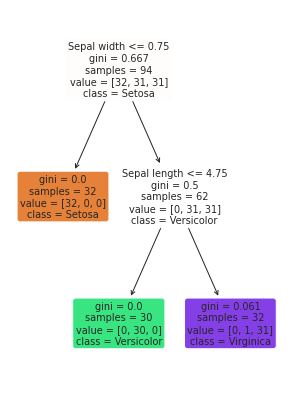

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


tree = DecisionTreeClassifier(max_depth=2, random_state=1)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
valid_acc = tree.score(X_valid, y_valid)
test_acc = tree.score(X_test, y_test)

print(f'Training accuracy: {train_acc*100:.2f}%')
print(f'Validation accuracy: {valid_acc*100:.2f}%')
print(f'Depth: {tree.get_depth()}')


plt.figure(figsize=(5, 7))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          feature_names=['Sepal length', 'Sepal width',
                         'Petal length', 'Petal width'],
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica']
         )

#plt.tight_layout()
plt.show()

# Cost Complexity Pruning

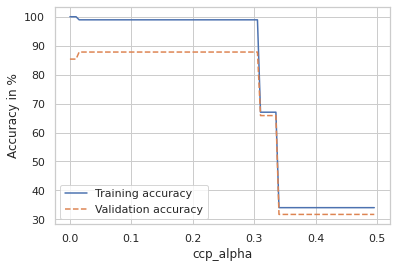

In [13]:
all_train_acc = []
all_valid_acc = []
all_hyperparam = []


for i in np.arange(0.0, 0.5, 0.005):
    tree = DecisionTreeClassifier(ccp_alpha=i, random_state=1)
    tree.fit(X_train, y_train)
    train_acc = tree.score(X_train, y_train)
    valid_acc = tree.score(X_valid, y_valid)
    
    all_train_acc.append(train_acc*100)
    all_valid_acc.append(valid_acc*100)
    all_hyperparam.append(i)
    
plt.plot(all_hyperparam, all_train_acc, label='Training accuracy')
plt.plot(all_hyperparam, all_valid_acc, ls='--', label='Validation accuracy')
plt.xlabel('ccp_alpha')
plt.ylabel('Accuracy in %')
plt.legend()
plt.show()

In [14]:
all_hyperparam[np.argmax(all_valid_acc)]

0.015

Training accuracy: 98.94%
Validation accuracy: 87.80%
Depth: 2


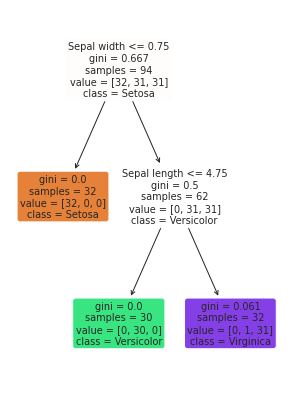

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree


tree = DecisionTreeClassifier(ccp_alpha=0.015, random_state=1)
tree.fit(X_train, y_train)

train_acc = tree.score(X_train, y_train)
valid_acc = tree.score(X_valid, y_valid)
test_acc = tree.score(X_test, y_test)

print(f'Training accuracy: {train_acc*100:.2f}%')
print(f'Validation accuracy: {valid_acc*100:.2f}%')
print(f'Depth: {tree.get_depth()}')


plt.figure(figsize=(5, 7))

plot_tree(tree, 
          filled=True, 
          rounded=True,
          feature_names=['Sepal length', 'Sepal width',
                         'Petal length', 'Petal width'],
          class_names=['Setosa', 
                       'Versicolor',
                       'Virginica']
         )

#plt.tight_layout()
plt.show()

# Decision Tree Regression

In [1]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/'
                 'housing/housing.data',
                 header=None,
                 sep='\s+')

df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:2076: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


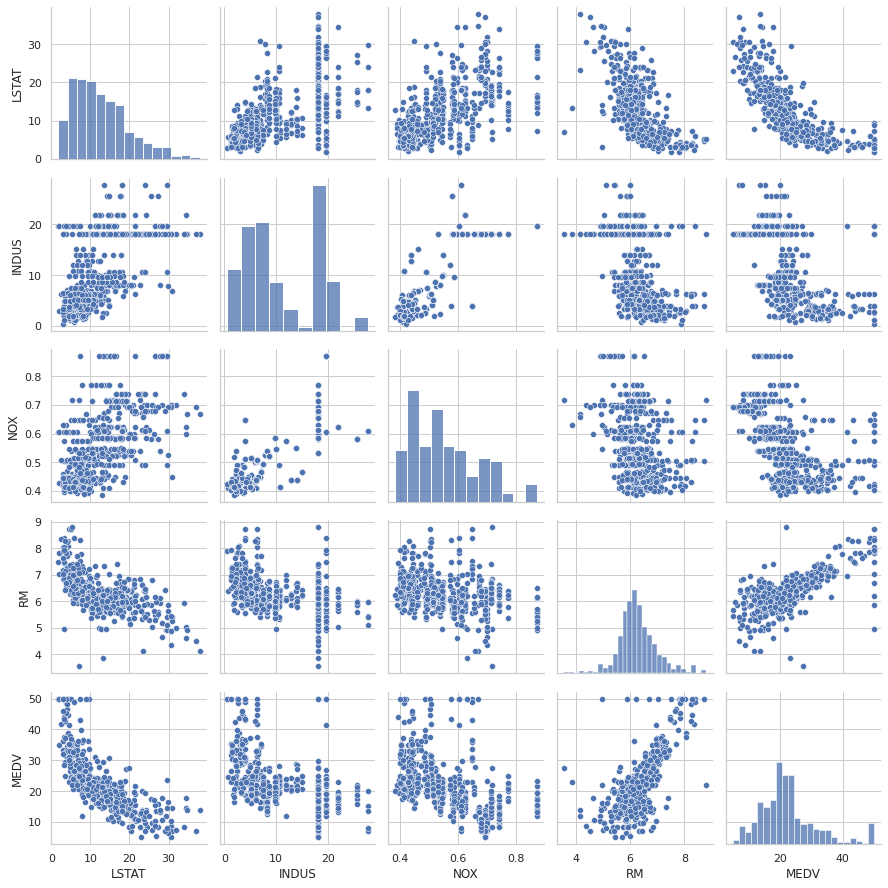

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='notebook')
cols = ['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']

sns.pairplot(df[cols], size=2.5)
plt.tight_layout()
plt.show()

In [3]:
def lin_regplot(X, y, model):
    plt.scatter(X, y, c='lightblue')
    plt.plot(X, model.predict(X), color='red', linewidth=2)    
    return 

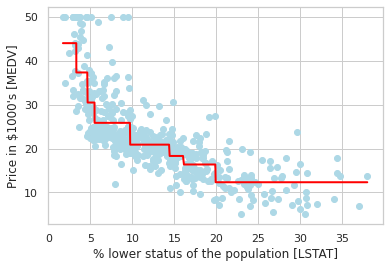

In [4]:
from sklearn.tree import DecisionTreeRegressor

X = df[['LSTAT']].values
y = df['MEDV'].values

tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000\'s [MEDV]')
plt.show()